<a href="https://colab.research.google.com/github/yacoan81/motorEvoked/blob/main/02_Modelling_LR%2BRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies and Packages

In [ ]:
# Run once, to be able to use oversampling
# pip install -U imbalanced-learn
!pip install ml_insights


In [ ]:
# sampling with imbalance data
# https://github.com/scikit-learn-contrib/imbalanced-learn#id32
from imblearn.over_sampling import RandomOverSampler
from imblearn import FunctionSampler  # to use a idendity sampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy as sp
import math
import warnings
import matplotlib.pyplot as plt 
import ml_insights as mli

warnings.filterwarnings('ignore')

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (train_test_split, GroupShuffleSplit, 
                                     GroupKFold, GridSearchCV, cross_val_predict,
                                     LeaveOneGroupOut, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, balanced_accuracy_score, roc_auc_score,
                             log_loss, make_scorer, accuracy_score, roc_curve,
                             auc)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import StandardScaler

from imblearn.ensemble import BalancedRandomForestClassifier



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Functions

def bins(prob,nbin):
  val= []
  for low in np.linspace(0,1,nbin):
    valz = prob[:,1][(prob[:,1]>= low) & (prob[:,1]<= low+(1/nbin))]
    val.append(len(valz))
  # print("Boundaries: {} - {} | freq: {}".format(low,low+0.1,len(val)))
  return val;

def reliability(name,y,probabilities,bins,strategy='uniform'):
  fraction_of_positives, mean_predicted_value = calibration_curve(y, probabilities[:,1], n_bins=bins, strategy=strategy)
  # bins_cal = len(fraction_of_positives)
  # bin_counts = pd.cut(probabilities[:,1], bins=bins_cal).value_counts()
  # ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value) * (bin_counts / len(y_test)))
  ece = expected_calibration_error(y=y, proba=probabilities[:,1], bins=bins)

  fig = plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))
  
  ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s | ECE: (%1.3f)" % (name, ece))

  ax2.hist(probabilities[:,1], range=(0, 1), bins=bins, label=name,histtype="step", lw=2)
  # ax2.hist(probabilities[:,1], range=(probabilities[:,1].min(), probabilities[:,1].max()), bins=bins, label=name,histtype="step", lw=2)
  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  
  ax1.set_ylabel("Fraction of positives")
  # ax1.set_xlim([probabilities[:,1].min(), probabilities[:,1].max()])
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots  (reliability curve)')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper center", ncol=2)

  plt.tight_layout()


def expected_calibration_error(y, proba, bins):
  bin_count, bin_edges = np.histogram(proba, bins = bins)
  n_bins = len(bin_count)
  bin_edges[0] -= 1e-8 # because left edge is not included
  bin_id = np.digitize(proba, bin_edges, right = True) - 1
  bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
  bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
  bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
  return ece

def get_group_split(groupvector, test_size):
    """split items according to their group label
    Input:
         groupvector  -- labels of the item groups
         test_size        -- desired size of the test set
    Output:
        train_keys      -- group labels of the items in the train set
        test_keys       -- group labels of the items in the test set
    """
    if type(test_size) is float:
        test_size = round(test_size*len(groupvector))

    # count number of items in each group
    gr_counts = Counter(groupvector)
    # randomly shuffle group keys
    gr_keys = np.random.choice(np.asarray(list(gr_counts.keys())), 
                                                    size = len(gr_counts), replace=False)

    # find the index of the group in the list `gr_keys` that optimally splits the set 
    # according to the specified `test_size`
    # to this end: 
    #   (1) calculate cumulative sum of items in the ordered list of groups
    cum_num_items = np.cumsum(np.array([gr_counts[x] for x in gr_keys]))
    # (2) find the group index so that the splitting yields the set of the size that is closest to the specified
    ind = np.argmin(abs(cum_num_items - test_size))
    if ind > (len(gr_counts) -1):
        print("split index", ind)
        print(
            abs(np.cumsum(np.array([gr_counts[x] for x in gr_keys])) - test_size)
            )
        raise ValueError("Unable to split")

    # split groups according to the obtained index
    test_keys = [kk for nn, kk in enumerate(gr_keys) if nn<=ind]
    train_keys = [kk for nn, kk in enumerate(gr_keys) if nn>ind]
    return train_keys, test_keys

def iterate_models(model,n,testSize):
  n = n
  brier = np.zeros(n)
  logloss = np.zeros(n)
  ece =  np.zeros(n)
  auc =  np.zeros(n)

  brier_iso = np.zeros(n)
  logloss_iso = np.zeros(n)
  ece_iso =  np.zeros(n)
  auc_iso =  np.zeros(n)

  brier_sig = np.zeros(n)
  logloss_sig = np.zeros(n)
  ece_sig =  np.zeros(n)
  auc_sig =  np.zeros(n)

  proportion_train = np.zeros(n)
  proportion_test = np.zeros(n)
  for i in range(n):
    train_keys,test_keys =  get_group_split(groups_all, test_size = testSize)

    test_mask = [x in set(test_keys) for x in groups_all]
    X_test_all =  X[test_mask]
    X_test_ = X_test_all.iloc[:,1:]
    xxtest = X_test_all.patient_uid.nunique()
    y_test_ =  y[test_mask]

    train_mask = [x in set(train_keys) for x in groups_all]
    X_train_all =  X[train_mask]
    X_train_ = X_train_all.iloc[:,1:]
    xxtrain = X_train_all.patient_uid.nunique()
    y_train_ =  y[train_mask]
    
    clf = model.fit(X_train_, y_train_)

    ########################Isotonic Calibration################################
    clf_iso = CalibratedClassifierCV(base_estimator=model, cv=4, method='isotonic')
    clf_iso.fit(X_train_, y_train_)
    proba_iso = clf_iso.predict_proba(X_test_)

    auc_iso[i] = roc_auc_score(y_test_, proba_iso[:,1])
    logloss_iso[i] = log_loss(y_test_, proba_iso)
    brier_iso[i] = brier_score_loss(y_test_, proba_iso[:,1])
    ece_iso[i] = expected_calibration_error(y_test_, proba_iso[:,1],10)
    ########################sigmoid Calibration################################
    clf_sig = CalibratedClassifierCV(base_estimator=model, cv=4, method='sigmoid')
    clf_sig.fit(X_train_, y_train_)
    proba_sig = clf_sig.predict_proba(X_test_)

    auc_sig[i] = roc_auc_score(y_test_, proba_sig[:,1])
    logloss_sig[i] = log_loss(y_test_, proba_sig)
    brier_sig[i] = brier_score_loss(y_test_, proba_sig[:,1])
    ece_sig[i] = expected_calibration_error(y_test_, proba_sig[:,1],10)
    ############################################################################
    y_pred = clf.predict(X_test_)
    proba = clf.predict_proba(X_test_)

    brier[i] = brier_score_loss(y_test_, proba[:,1])
    logloss[i] = log_loss(y_test_, proba)
    ece[i] = expected_calibration_error(y_test_, proba[:,1],10)
    auc[i] = roc_auc_score(y_test_, proba[:,1])
    
    proportion_train[i] = xxtest/groups_all.nunique()
    proportion_test[i]  = xxtrain/groups_all.nunique()
  return auc, logloss, brier, ece, proportion_train, proportion_test,\
         auc_iso,logloss_iso,brier_iso,ece_iso,\
         auc_sig,logloss_sig,brier_sig,ece_sig


# Import Data

In [ ]:

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

final = '18ItiyhgcSV61_OHKV8tMCiXDnGXPYPBa'

In [ ]:
downloaded = drive.CreateFile({'id':final}) 
downloaded.GetContentFile('final.csv')  
final = pd.read_csv('final.csv')

In [ ]:
final_Copy = final.copy()

In [ ]:
final.shape

(2139, 21)

In [ ]:
# final.head()

In [ ]:
#removing imported column
final.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
Counter(final['w'])

Counter({0: 1889, 1: 250})

In [ ]:
print("proportion of positive outcomes: {}".format(final[(final["w"]==1)].size / final.size * 100))

proportion of positive outcomes: 11.68770453482936


In [ ]:
final.corr()

,patient_uid,age,visit_uid,edss0,edss1,delta_edss,AH-L,diff_AH-L,AH-R,diff_AH-R,APB-L,diff_APB-L,APB-R,diff_APB-R,w
patient_uid,1.000000,-0.020611,-0.001264,-0.064710,-0.076411,-0.043581,-0.099198,-0.009200,-0.073226,-0.000746,-0.080784,-0.014768,-0.064911,-0.006223,-0.022800
age,-0.020611,1.000000,0.054465,0.471567,0.487577,0.105579,0.243753,0.019923,0.262769,0.009468,0.168068,0.009739,0.168989,0.000875,0.091827
visit_uid,-0.001264,0.054465,1.000000,0.027436,0.027336,0.002986,-0.017369,0.002059,-0.030755,-0.010146,-0.046188,0.020483,-0.061856,-0.004081,-0.041126
edss0,-0.064710,0.471567,0.027436,1.000000,0.945267,-0.047590,0.456015,0.053695,0.487893,-0.007256,0.422514,0.035186,0.412071,0.022719,0.116489
edss1,-0.076411,0.487577,0.027336,0.945267,1.000000,0.280943,0.446497,0.043197,0.488515,-0.009840,0.416125,0.023880,0.411695,0.012900,0.340933
delta_edss,-0.043581,0.105579,0.002986,-0.047590,0.280943,1.000000,0.025564,-0.025693,0.060431,-0.008780,0.031125,-0.030390,0.048279,-0.027334,0.701046
AH-L,-0.099198,0.243753,-0.017369,0.456015,0.446497,0.025564,1.000000,0.275492,0.747348,0.098091,0.659009,0.088521,0.574491,0.057352,0.119962
diff_AH-L,-0.009200,0.019923,0.002059,0.053695,0.043197,-0.025693,0.275492,1.000000,0.094763,0.241140,0.043872,0.157777,0.035048,0.100374,-0.003684
AH-R,-0.073226,0.262769,-0.030755,0.487893,0.488515,0.060431,0.747348,0.094763,1.000000,0.255524,0.613544,0.040086,0.672034,0.073405,0.166342
diff_AH-R,-0.000746,0.009468,-0.010146,-0.007256,-0.009840,-0.008780,0.098091,0.241140,0.255524,1.000000,-0.032016,0.011893,0.013662,0.144170,0.021612


In [ ]:
test = final[['sex', 'age', 'edss0', 'AH-L', 'diff_AH-L','AH-R', 'diff_AH-R', 'APB-L', 'diff_APB-L', 'APB-R', 'diff_APB-R', 'w' ]]


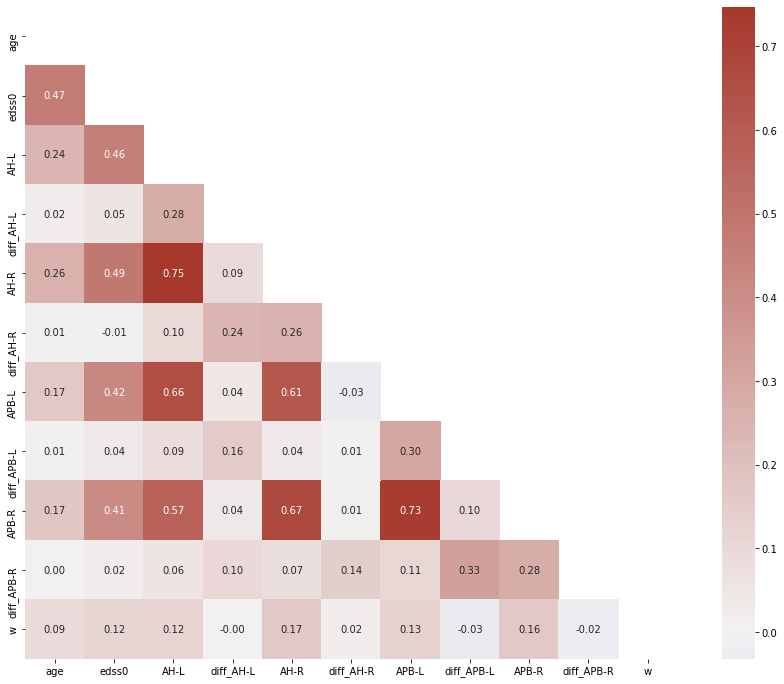

In [ ]:
import seaborn as sns 
# Calculate pairwise-correlation
matrix = test.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.show();

# Preparation

In [ ]:
final.columns

Index(['patient_uid', 'sex', 'age', 'date_of_birth', 'visit_uid', 'visit_date',
       'dateT0', 'edss0', 'dateT1', 'edss1', 'delta_edss', 'AH-L', 'diff_AH-L',
       'AH-R', 'diff_AH-R', 'APB-L', 'diff_APB-L', 'APB-R', 'diff_APB-R', 'w'],
      dtype='object')

In [ ]:
final_=pd.get_dummies(final, columns=["sex"])
final_.drop('sex_Female', axis=1, inplace=True)

In [ ]:
final_['visit_date'] = pd.to_datetime(final_['visit_date'], format='%Y/%m/%d', errors='coerce')
final_['dateT0'] = pd.to_datetime(final_['dateT0'], format='%Y/%m/%d', errors='coerce')
final_['dateT1'] = pd.to_datetime(final_['dateT1'], format='%Y/%m/%d', errors='coerce')
final_['date_of_birth'] = pd.to_datetime(final_['date_of_birth'], format='%Y/%m/%d', errors='coerce')

In [ ]:
final_.dtypes

patient_uid               int64
age                     float64
date_of_birth    datetime64[ns]
visit_uid                 int64
visit_date       datetime64[ns]
dateT0           datetime64[ns]
edss0                   float64
dateT1           datetime64[ns]
edss1                   float64
delta_edss              float64
AH-L                    float64
diff_AH-L               float64
AH-R                    float64
diff_AH-R               float64
APB-L                   float64
diff_APB-L              float64
APB-R                   float64
diff_APB-R              float64
w                         int64
sex_Male                  uint8
dtype: object

In [ ]:
# how much visits disappear if you filter on "MEP visit outside 1 year of EDSS visit" 
Counter((final_['dateT0'] - final_['visit_date']).dt.days.abs() > 365)

Counter({False: 2139})

In [ ]:
cols = ['patient_uid','age','edss0','sex_Male','AH-L','AH-R','APB-L','APB-R','diff_AH-L','diff_AH-R','diff_APB-L','diff_APB-R']

In [ ]:
X = final_[cols]
y = final_['w'].astype('int')

In [ ]:
X.head()

,patient_uid,age,edss0,sex_Male,AH-L,AH-R,APB-L,APB-R,diff_AH-L,diff_AH-R,diff_APB-L,diff_APB-R
0,2,25.002053,2.5,0,33.958333,34.427083,16.770833,17.187500,0.000000,0.000000,0.000000,0.000000
1,7,73.141684,4.0,0,41.510417,42.864583,22.135417,20.104167,0.610417,1.914583,-1.014583,-1.095833
2,7,72.643395,4.0,0,40.900000,40.950000,23.150000,21.200000,0.275000,0.116667,0.285417,1.095833
3,7,71.638604,4.0,0,40.625000,40.833333,22.864583,20.104167,0.000000,-0.312500,3.697916,-2.083333
4,7,70.642026,3.5,0,40.625000,41.145833,19.166667,22.187500,-1.614583,1.458333,-0.885416,3.437500


## Split Train and Test Sets

We need to split between train and test sosame  patient is not in both splits \\


In [ ]:
groups_all = X['patient_uid']
groups_all.nunique()

495

In [ ]:
## 
train_idx, test_idx = next(GroupShuffleSplit(train_size=.8, random_state=42).split(X, y, groups_all))

In [ ]:
X_train = np.take(X, train_idx, axis=0)
y_train = np.take(y, train_idx, axis=0)
groups_X_train = X_train['patient_uid']

X_test = np.take(X, test_idx, axis=0)
y_test = np.take(y, test_idx, axis=0)

In [ ]:
# taking the patients (groups) apart in case is needed later on
groups_X_test = X_test['patient_uid']
X_test = X_test.iloc[:,1:]

In [ ]:
X_train.shape, groups_X_train.nunique()

((1723, 12), 396)

In [ ]:
X_test.shape, groups_X_test.nunique()

((416, 11), 99)

## Scaling

In [ ]:
# Remark: Scaling in training set and apply fit in both train and test


In [ ]:
# cols to scale, although we can apply it in all
col_names = ['age', 'edss0','AH-L',	'AH-R',	'APB-L',	'APB-R', 'diff_AH-L', 'diff_AH-R', 'diff_APB-L', 'diff_APB-R']
features = X_train[col_names]
# scaler contains the scaling function 
scaler = StandardScaler().fit(features.values)

X_train_scaled = scaler.transform(X_train[col_names].values)
X_test_scaled  = scaler.transform(X_test[col_names].values)

X_train[col_names] = X_train_scaled
X_test[col_names] = X_test_scaled


In [ ]:
Counter(y_train), Counter(y_test)

(Counter({0: 1524, 1: 199}), Counter({0: 365, 1: 51}))

## Oversampling

In [ ]:
def func(X, y, sampling_strategy, random_state):
  return RandomOverSampler(
      sampling_strategy=sampling_strategy,
      random_state=random_state).fit_resample(X, y)

sampler = FunctionSampler(func=func,
                          kw_args={'sampling_strategy': 'auto',
                                   'random_state': 42})
X_train_overSampled, y_train_overSampled = sampler.fit_resample(X_train, y_train)

In [ ]:
# RandomOverSampler returns numpy ndarray, transform to dataframe 
X_train_overSampled = pd.DataFrame(X_train_overSampled)
X_train_overSampled.columns =  cols
X_train_overSampled['sex_Male'] = X_train_overSampled['sex_Male'].astype(int)
X_train_overSampled['patient_uid'] = X_train_overSampled['patient_uid'].astype(int)

groups_X_train_overSampled = X_train_overSampled['patient_uid']

In [ ]:
# In case we want to try, split the train set into train and calibration, for both oversampled and non-oversampled

train_idx_1, test_idx_1 = next(GroupShuffleSplit(train_size=.50, random_state=42).split(X_train, y_train, groups_X_train))
X_train_cali = np.take(X_train, train_idx_1, axis=0)
y_train_cali = np.take(y_train, train_idx_1, axis=0)
X_calib = np.take(X_train, test_idx_1, axis=0)
y_calib = np.take(y_train, test_idx_1, axis=0)
groups_X_train_cali = X_train_cali['patient_uid']
groups_X_calib = X_calib['patient_uid']
X_train_cali = X_train_cali.iloc[:,1:]
X_calib = X_calib.iloc[:,1:]

# with oversampled train data
train_idx_2, test_idx_2 = next(GroupShuffleSplit(train_size=.50, random_state=42).split(X_train_overSampled, y_train_overSampled, groups_X_train_overSampled))
X_train_2 = np.take(X_train_overSampled, train_idx_2, axis=0)
y_train_2 = np.take(y_train_overSampled, train_idx_2, axis=0)
X_calib_2 = np.take(X_train_overSampled, test_idx_2, axis=0)
y_calib_2 = np.take(y_train_overSampled, test_idx_2, axis=0)
groups_X_train_2 = X_train_2['patient_uid']
groups_X_calib_2 = X_calib_2['patient_uid']
X_train_2 = X_train_2.iloc[:,1:]
X_calib_2 = X_calib_2.iloc[:,1:]

groups_X_train = X_train['patient_uid']
X_train = X_train.iloc[:,1:]

groups_X_train_overSampled = X_train_overSampled['patient_uid']
X_train_overSampled = X_train_overSampled.iloc[:,1:]



# Logistic Regression

## normal


### Tuning

In [ ]:
# p_grid={"C":np.logspace(-5,5,20), "penalty":["l1","l2"], "solver":['liblinear']} # 
# # Logit with L1 regulation (Lasso) should do good

# cv = GroupKFold(n_splits=4)

# Model_logistic = LogisticRegression(random_state=42)

# clf_logistic = RandomizedSearchCV(estimator=Model_logistic, param_distributions=p_grid, n_iter = 100, cv=cv, scoring = 'brier_score_loss', verbose=2, random_state=42, n_jobs = -1)

# clf_logistic.fit(X_train, y_train, groups_X_train)

# print(clf_logistic.best_score_)
# print(clf_logistic.best_params_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-0.09964181552025594
{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1623776739188721}


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.2s finished


In [ ]:
# Fitting 4 folds for each of 40 candidates, totalling 160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# -0.09964181552025594
# {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1623776739188721}
# [Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    2.0s
# [Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.2s finished

In [ ]:
best_para_logic = {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1623776739188721}
# best_para_logic = clf_logistic.best_params_
Model_logistic_refit = LogisticRegression(random_state=42)
Model_logistic_refit.set_params(**best_para_logic)

LogisticRegression(C=0.1623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
auc_lr,logloss_lr,brier_lr,ece_lr,prop_train,prop_test,auc_iso_lr,logloss_iso_lr,brier_iso_lr,ece_iso_lr,auc_sig_lr,logloss_sig_lr,brier_sig_lr,ece_sig_lr = iterate_models(Model_logistic_refit,100,0.2)

In [ ]:
auc_lr

array([0.58283603, 0.52987862, 0.56427493, 0.62966   , 0.52751932,
       0.64485306, 0.55670103, 0.58649789, 0.60582011, 0.51946283,
       0.60233006, 0.57308715, 0.59056488, 0.52744321, 0.5867491 ,
       0.59887137, 0.61112409, 0.63227883, 0.58283358, 0.52811081,
       0.55801971, 0.53614338, 0.56963454, 0.53337585, 0.58106588,
       0.52648649, 0.68827839, 0.54990912, 0.62220513, 0.6283443 ,
       0.56825718, 0.54407264, 0.5768262 , 0.54678065, 0.61675258,
       0.53839532, 0.59635897, 0.68431603, 0.49012297, 0.51775552,
       0.49436528, 0.51928164, 0.56676485, 0.67000365, 0.55649886,
       0.6295834 , 0.58167311, 0.59164524, 0.65236121, 0.5896476 ,
       0.57586683, 0.5615835 , 0.59398936, 0.70026525, 0.46640958,
       0.63150047, 0.63790476, 0.5687664 , 0.49133333, 0.65009009,
       0.64255319, 0.46949959, 0.51157025, 0.52391892, 0.53774545,
       0.61139674, 0.74691293, 0.58723943, 0.58433269, 0.61185651,
       0.57675691, 0.52173228, 0.54545982, 0.60303699, 0.56933

In [ ]:
auc_iso_lr

array([0.62098608, 0.49068887, 0.56749897, 0.6462503 , 0.48454502,
       0.66437976, 0.57226668, 0.62675809, 0.52910053, 0.51170202,
       0.62773704, 0.57183408, 0.55397206, 0.47006552, 0.58339058,
       0.51963513, 0.60791073, 0.60607809, 0.52719734, 0.52822434,
       0.53353495, 0.51767451, 0.53946193, 0.52044359, 0.5637275 ,
       0.49831081, 0.64310134, 0.5561614 , 0.58982051, 0.53067434,
       0.53401345, 0.51905223, 0.5329555 , 0.52525856, 0.60757088,
       0.50985709, 0.56841026, 0.69461533, 0.48394165, 0.48338265,
       0.44242228, 0.52579365, 0.54047005, 0.67285349, 0.49821269,
       0.59328028, 0.56595745, 0.53907455, 0.60710247, 0.58954777,
       0.5580494 , 0.5449427 , 0.54425532, 0.67478413, 0.37677593,
       0.54193849, 0.63683333, 0.53375328, 0.46754762, 0.61036036,
       0.63757979, 0.49157361, 0.43164109, 0.47736486, 0.52227879,
       0.62089403, 0.69240106, 0.60272322, 0.54366538, 0.56346489,
       0.53151402, 0.45832021, 0.48746736, 0.5941791 , 0.57154

In [ ]:
auc_sig_lr

array([0.64926115, 0.48500882, 0.55947318, 0.60742706, 0.48141723,
       0.6265763 , 0.55032556, 0.60611814, 0.53876471, 0.65030167,
       0.62370625, 0.56515957, 0.5720333 , 0.47157597, 0.56911686,
       0.53733766, 0.57227156, 0.60975165, 0.51649175, 0.49750227,
       0.60887097, 0.54632112, 0.68900804, 0.51318027, 0.57216653,
       0.49162162, 0.51709402, 0.57062886, 0.76338462, 0.49270833,
       0.7229182 , 0.4933687 , 0.55104954, 0.53177497, 0.58350515,
       0.52539601, 0.52435897, 0.66309532, 0.47605965, 0.49032552,
       0.42772021, 0.50152625, 0.55516691, 0.65524297, 0.53604409,
       0.61320019, 0.5754352 , 0.55565553, 0.60454472, 0.57587102,
       0.55591611, 0.52645013, 0.55569149, 0.69411366, 0.43495027,
       0.58588071, 0.62290476, 0.54272966, 0.45595238, 0.45662162,
       0.66069149, 0.45202647, 0.44391972, 0.46527027, 0.50293333,
       0.61932305, 0.33419525, 0.61097723, 0.59951644, 0.55594229,
       0.52553763, 0.47622047, 0.46684073, 0.61504496, 0.55604

In [ ]:
for size in [0.2,0.3,0.5,0.8]:
  auc,logloss,brier,ece,prop_train,prop_test,auc_iso,logloss_iso,brier_iso,ece_iso,auc_sig,logloss_sig,brier_sig,ece_sig = iterate_models(Model_logistic_refit,1000,size)
  print('*'*70)

  print("\tTest Set Size: %.2f\n\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (size,
                                                                                                                           auc.mean(),auc.std(),
                                                                                                                           logloss.mean(),logloss.std(),
                                                                                                                           brier.mean(),brier.std(),
                                                                                                                           ece.mean(),ece.std()) )
  print("\n")
  print("\tAUC(min): %1.3f      \tAUC(max): %1.3f"    % (auc.min(),auc.max()))
  print("\tlog_loss(min): %1.3f  \tlog_loss(max): %1.3f" % (logloss.min(),logloss.max()))
  print("\tBrier(min): %1.3f    \tBrier(max): %1.3f"   % (brier.min(),brier.max()))
  print("\tECE(min): %1.3f       \tECE(max): %1.3f"      % (ece.min(),ece.max()))
  print("\tProp train: %.2f \tProp test: %.2f" % (prop_train.mean(), prop_test.mean()))  
  print("\nIsotonic Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_iso.mean(),auc_iso.std(),
                                                                                                                           logloss_iso.mean(),logloss_iso.std(),
                                                                                                                           brier_iso.mean(),brier_iso.std(),
                                                                                                                           ece_iso.mean(),ece_iso.std()) )
  print("\nSigmoid Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_sig.mean(),auc_sig.std(),
                                                                                                                           logloss_sig.mean(),logloss_sig.std(),
                                                                                                                           brier_sig.mean(),brier_sig.std(),
                                                                                                                           ece_sig.mean(),ece_sig.std()) )

KeyboardInterrupt: ignored

In [ ]:
clf_logistic_refit = Model_logistic_refit.fit(X_train, y_train)

y_pred_logistic_refit = clf_logistic_refit.predict(X_test)
proba_logistic_uncalibrated_refit = clf_logistic_refit.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_logistic_refit.score(X_test, y_test))
print("\tF1: %1.3f (best is 1, worst is 0)" % f1_score(y_test, y_pred_logistic_refit))
print("\tPrecision: %1.3f (best is 1, worst is 0)" % precision_score(y_test, y_pred_logistic_refit))
print("\tRecall: %1.3f (best is 1, worst is 0)" % recall_score(y_test, y_pred_logistic_refit))
print("\tbal_acc: %1.3f (best is 1, worst is 0)" % balanced_accuracy_score(y_test, y_pred_logistic_refit))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_logistic_uncalibrated_refit[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_logistic_uncalibrated_refit))
print("\tBrier: %1.3f (smaller the better)" % brier_score_loss(y_test, proba_logistic_uncalibrated_refit[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_logistic_uncalibrated_refit[:,1],10))

	score: 0.877
	F1: 0.038 (best is 1, worst is 0)
	Precision: 0.500 (best is 1, worst is 0)
	Recall: 0.020 (best is 1, worst is 0)
	bal_acc: 0.508 (best is 1, worst is 0)
	auc: 0.643
	log_loss: 0.363
	Brier: 0.106 (smaller the better)
	ECE: 0.029 (smaller the better)


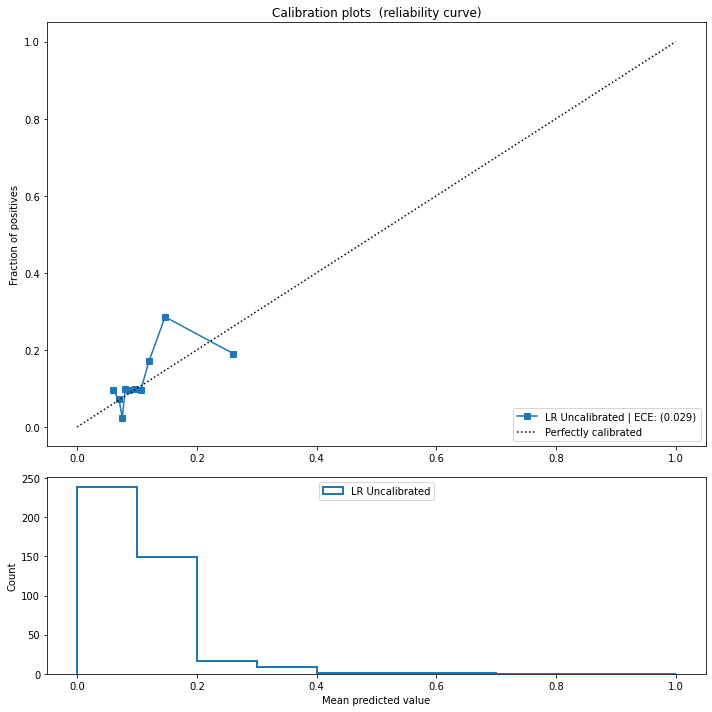

In [ ]:
reliability("LR Uncalibrated", y_test, proba_logistic_uncalibrated_refit,10,'quantile')

### Calibration Logistic Regression Platt (sigmoid)



In [ ]:
# Model_logistic_refit
# clf_logistic_refit

# Calibrated with sigmoid calibration
clf_logistic_refit_sigmoid = CalibratedClassifierCV(base_estimator=Model_logistic_refit, cv=4, method='sigmoid')

clf_logistic_refit_sigmoid.fit(X_train, y_train)

y_pred_logistic_refit_sigmoid = clf_logistic_refit_sigmoid.predict(X_test)
proba_logistic_refit_sigmoid = clf_logistic_refit_sigmoid.predict_proba(X_test)

In [ ]:
# auc_lr,logloss_lr,brier_lr,ece_lr = iterate_models(clf_logistic_refit_sigmoid,100)

In [ ]:
# print("\tAUC %1.3f | log_loss: %1.3f\n\tBrier: %1.3f | ECE: %1.3f" % (auc_lr,logloss_lr,brier_lr,ece_lr))

In [ ]:
print("\tscore: %1.3f" % clf_logistic_refit_sigmoid.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_logistic_refit_sigmoid[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_logistic_refit_sigmoid))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_logistic_refit_sigmoid[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_logistic_refit_sigmoid[:,1],10))

	score: 0.880
	F1: 0.038
	Precision: 1.000
	Recall: 0.020
	bal_acc: 0.510
	auc: 0.651
	log_loss: 0.362
	Brier: 0.105
	ECE: 0.030 (smaller the better)


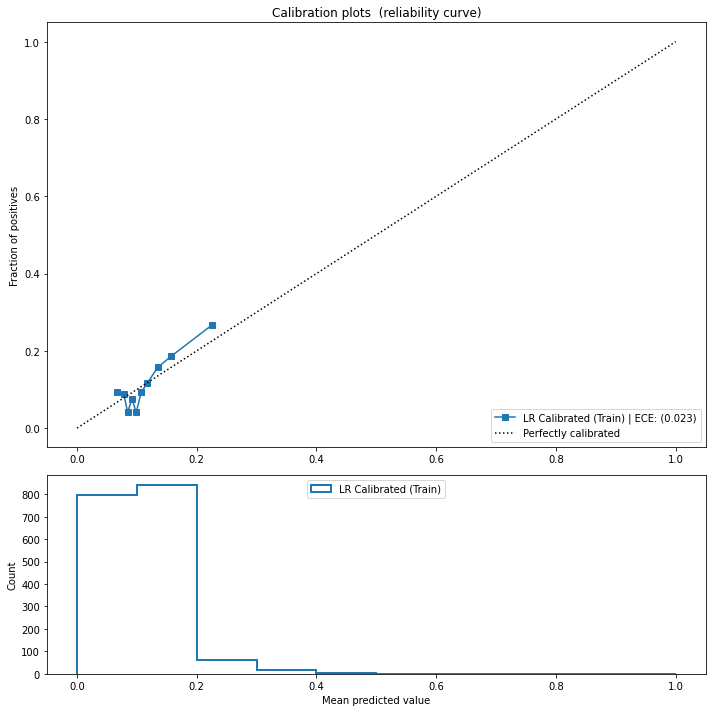

In [ ]:
reliability("LR Calibrated (Train)", y_train, clf_logistic_refit_sigmoid.predict_proba(X_train), 10,'quantile')

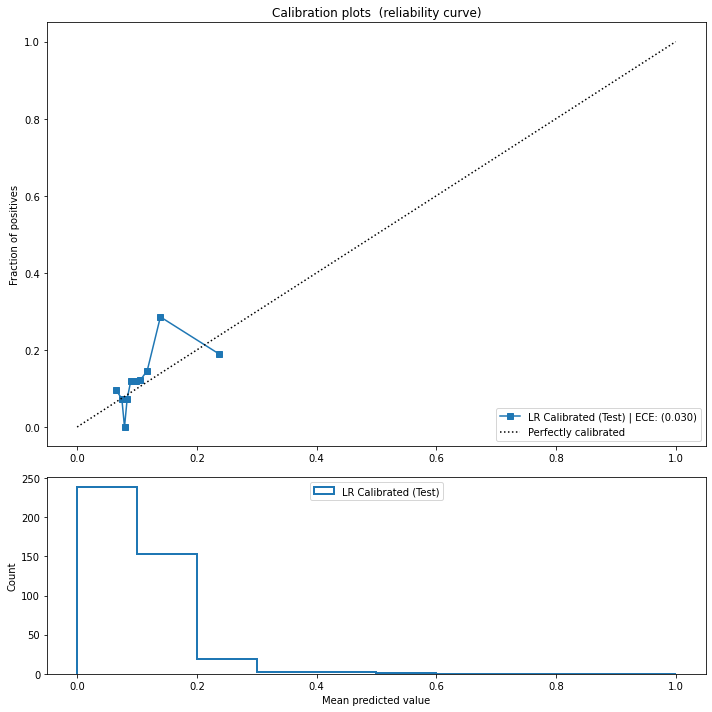

In [ ]:
reliability("LR Calibrated (Test)", y_test, proba_logistic_refit_sigmoid, 10,'quantile')

### Calibration Logistic Regression Platt (Isotonic)





In [ ]:
# Model_logistic_refit
# clf_logistic_refit

# Calibrated with sigmoid calibration
clf_logistic_refit_iso = CalibratedClassifierCV(base_estimator=Model_logistic_refit, cv=4, method='isotonic')

clf_logistic_refit_iso.fit(X_train, y_train)

y_pred_logistic_refit_iso = clf_logistic_refit_iso.predict(X_test)
proba_logistic_refit_iso = clf_logistic_refit_iso.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_logistic_refit_iso.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_logistic_refit_iso))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_logistic_refit_iso))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_logistic_refit_iso))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_logistic_refit_iso))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_logistic_refit_iso[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_logistic_refit_iso))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_logistic_refit_iso[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_logistic_refit_iso[:,1],10))

	score: 0.873
	F1: 0.036
	Precision: 0.250
	Recall: 0.020
	bal_acc: 0.506
	auc: 0.636
	log_loss: 0.367
	Brier: 0.107
	ECE: 0.032 (smaller the better)


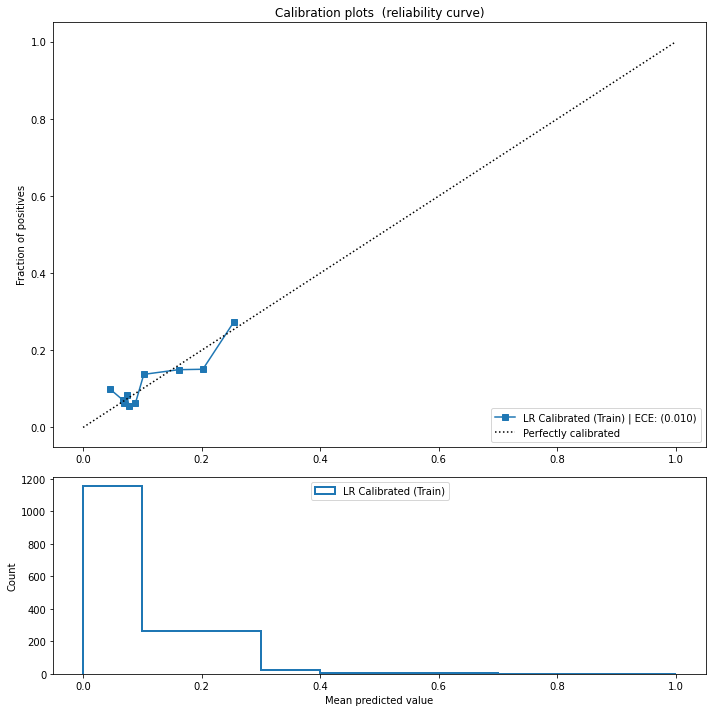

In [ ]:
reliability("LR Calibrated (Train)", y_train, clf_logistic_refit_iso.predict_proba(X_train), 10, 'quantile')

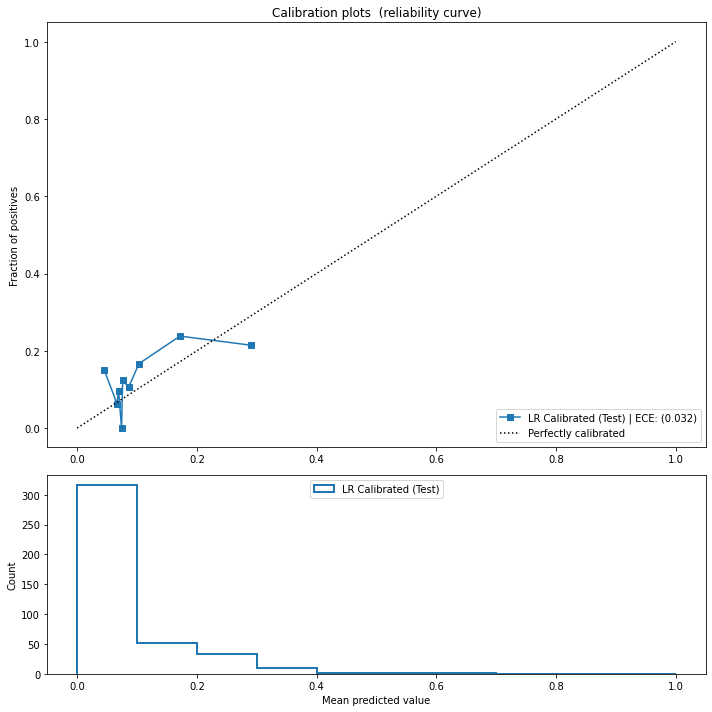

In [ ]:
reliability("LR Calibrated (Test)", y_test, proba_logistic_refit_iso, 10, 'quantile')

## with Weight

### Tuning

In [ ]:
p_grid={
    "C":np.logspace(-5,5,10), 
    "penalty":["l1","l2"], 
    "solver":['liblinear']}
    # "class_weight": w} # 
# Logit with L1 regulation (Lasso) should do good

cv = GroupKFold(n_splits=4)

# Model_logistic = LogisticRegression(random_state=42)
Model_logistic = LogisticRegression(random_state=42,class_weight='balanced')

clf_logistic = RandomizedSearchCV(estimator=Model_logistic, param_distributions=p_grid, n_iter = 100, cv=cv, scoring = 'brier_score_loss', verbose=2, random_state=42, n_jobs = -1)

clf_logistic.fit(X_train, y_train, groups_X_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished


RandomizedSearchCV(cv=GroupKFold(n_splits=4), error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                             

In [ ]:
print(clf_logistic.best_score_)
print(clf_logistic.best_params_)

-0.23101545468036438
{'solver': 'liblinear', 'penalty': 'l2', 'C': 100000.0}


In [ ]:
best_para_logic = {'solver': 'liblinear', 'penalty': 'l2', 'C': 100000.0}

# # best_para_logic = clf_logistic.best_params_

Model_logistic_refit = LogisticRegression(random_state=42,class_weight='balanced')
Model_logistic_refit.set_params(**best_para_logic)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# from sklearn.utils import class_weight
# class_weight.compute_class_weight('balanced', np.unique(y), y)
# np.unique(y),weights


array([0.56617258, 4.278     ])

In [ ]:
# 
# / (2*np.bincount(y))
# uno = y.shape[0] / (2*np.bincount(y)[1])
# zero, uno
# y.shape[0] / 2*np.bincount(y)
# y.shape[0] = 2139
# np.bincount(y) = 1889,  250
2139 / (2*250),2139 / (2*1889)

(4.278, 0.5661725780836422)

In [ ]:
auc_lrw,logloss_lrw,brier_lrw,ece_lrw,prop_train,prop_test,auc_iso_lrw,logloss_iso_lrw,brier_iso_lrw,ece_iso_lrw,auc_sig_lrw,logloss_sig_lrw,brier_sig_lrw,ece_sig_lrw = iterate_models(Model_logistic_refit,100,0.2)

In [ ]:
# np.mean(auc_lrw)
auc_lrw

array([0.75279513, 0.59912281, 0.68586171, 0.5721519 , 0.61692084,
       0.6832981 , 0.66485333, 0.5731982 , 0.50854592, 0.68455497,
       0.68057719, 0.65201328, 0.58037757, 0.48331883, 0.60212111,
       0.58365537, 0.63159838, 0.67220745, 0.70153207, 0.64750656,
       0.71250363, 0.58350075, 0.66634791, 0.64654876, 0.59771489,
       0.57474298, 0.57667824, 0.62358941, 0.59949608, 0.66673166,
       0.57726128, 0.64864184, 0.6418718 , 0.66955916, 0.67866741,
       0.62995951, 0.58758553, 0.5937037 , 0.62320738, 0.60075955,
       0.54615999, 0.63325711, 0.7320447 , 0.56485007, 0.6361758 ,
       0.71750304, 0.52764952, 0.74489318, 0.57078598, 0.66512464,
       0.61731277, 0.67612642, 0.54954955, 0.59932938, 0.62929835,
       0.61479815, 0.6902037 , 0.70572391, 0.62105845, 0.63665335,
       0.56818182, 0.59695095, 0.61315311, 0.63305322, 0.66517857,
       0.68781154, 0.65012874, 0.63682171, 0.60477454, 0.61618109,
       0.59568011, 0.6252549 , 0.56799832, 0.60571809, 0.61382

In [ ]:
auc_iso_lrw

array([0.75048192, 0.61557018, 0.69592363, 0.56363636, 0.63191202,
       0.64261552, 0.65272   , 0.56655405, 0.51278699, 0.68054291,
       0.66706367, 0.64499792, 0.57145309, 0.50968959, 0.60485802,
       0.58679126, 0.62513843, 0.67220745, 0.6571449 , 0.67734908,
       0.71552074, 0.58343797, 0.66106557, 0.64609804, 0.59472565,
       0.57180235, 0.56267361, 0.62339952, 0.59666853, 0.68120887,
       0.54966639, 0.6511943 , 0.64501584, 0.6441427 , 0.71139418,
       0.63259109, 0.60398338, 0.61478836, 0.6292397 , 0.55625445,
       0.53218076, 0.63929116, 0.69652673, 0.5776416 , 0.62777126,
       0.71292403, 0.52880387, 0.74768085, 0.57087476, 0.65270604,
       0.62096611, 0.65723425, 0.53409091, 0.59007395, 0.63950176,
       0.62335958, 0.68065927, 0.68459596, 0.61190762, 0.64651727,
       0.54412633, 0.58843316, 0.61633187, 0.64506962, 0.68067956,
       0.67487539, 0.65869479, 0.61531008, 0.60287988, 0.61950157,
       0.61553442, 0.61019608, 0.5681556 , 0.59556567, 0.62493

In [ ]:
auc_sig_lrw

array([0.74462179, 0.59895833, 0.68405573, 0.58726506, 0.61137047,
       0.68088191, 0.66586667, 0.5695045 , 0.51052296, 0.68159572,
       0.67361429, 0.64786218, 0.58226545, 0.48900493, 0.61423195,
       0.58834336, 0.62950658, 0.68519845, 0.69272623, 0.65275591,
       0.71876994, 0.58257994, 0.66912568, 0.64869505, 0.59718347,
       0.57599333, 0.57152778, 0.62613932, 0.60957447, 0.65868876,
       0.58216606, 0.64423016, 0.64318791, 0.68011141, 0.70195969,
       0.62759784, 0.58963832, 0.60539683, 0.62434555, 0.58010919,
       0.54946936, 0.64233994, 0.73488372, 0.56568301, 0.62271737,
       0.71054107, 0.52583553, 0.74259745, 0.5719697 , 0.65322255,
       0.61792166, 0.67634514, 0.53972154, 0.59542511, 0.63479759,
       0.61654793, 0.68706641, 0.71010101, 0.63027844, 0.63796854,
       0.55531287, 0.58528646, 0.61192435, 0.63341858, 0.66331845,
       0.67392594, 0.64289958, 0.65600775, 0.60771125, 0.61425307,
       0.60104204, 0.62023529, 0.56694977, 0.60684329, 0.61075

In [ ]:

  auc,logloss,brier,ece,prop_train,prop_test,auc_iso,logloss_iso,brier_iso,ece_iso,auc_sig,logloss_sig,brier_sig,ece_sig = iterate_models(Model_logistic_refit,1000,size)
  print('*'*70)

  print("\tTest Set Size: %.2f\n\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (size,
                                                                                                                           auc.mean(),auc.std(),
                                                                                                                           logloss.mean(),logloss.std(),
                                                                                                                           brier.mean(),brier.std(),
                                                                                                                           ece.mean(),ece.std()) )
  print("\n")
  print("\tAUC(min): %1.3f      \tAUC(max): %1.3f"    % (auc.min(),auc.max()))
  print("\tlog_loss(min): %1.3f  \tlog_loss(max): %1.3f" % (logloss.min(),logloss.max()))
  print("\tBrier(min): %1.3f    \tBrier(max): %1.3f"   % (brier.min(),brier.max()))
  print("\tECE(min): %1.3f       \tECE(max): %1.3f"      % (ece.min(),ece.max()))
  print("\tProp train: %.2f \tProp test: %.2f" % (prop_train.mean(), prop_test.mean()))  
  print("\nIsotonic Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_iso.mean(),auc_iso.std(),
                                                                                                                           logloss_iso.mean(),logloss_iso.std(),
                                                                                                                           brier_iso.mean(),brier_iso.std(),
                                                                                                                           ece_iso.mean(),ece_iso.std()) )
  print("\nSigmoid Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_sig.mean(),auc_sig.std(),
                                                                                                                           logloss_sig.mean(),logloss_sig.std(),
                                                                                                                           brier_sig.mean(),brier_sig.std(),
                                                                                                                           ece_sig.mean(),ece_sig.std()) )

**********************************************************************
	Test Set Size: 0.20
	Mean AUC: 0.612(0.054) 
	Mean log_loss: 0.665(0.026)
	Mean Brier: 0.233(0.012) 
	Mean ECE: 0.355(0.023)


	AUC(min): 0.407      	AUC(max): 0.777
	log_loss(min): 0.594  	log_loss(max): 0.765
	Brier(min): 0.200    	Brier(max): 0.278
	ECE(min): 0.256       	ECE(max): 0.416
	Prop train: 0.20 	Prop test: 0.80

Isotonic Calibration
	Mean AUC: 0.611(0.053) 
	Mean log_loss: 0.362(0.049)
	Mean Brier: 0.102(0.015) 
	Mean ECE: 0.040(0.015)

Sigmoid Calibration
	Mean AUC: 0.611(0.053) 
	Mean log_loss: 0.354(0.041)
	Mean Brier: 0.101(0.015) 
	Mean ECE: 0.039(0.014)
**********************************************************************
	Test Set Size: 0.30
	Mean AUC: 0.613(0.039) 
	Mean log_loss: 0.665(0.024)
	Mean Brier: 0.233(0.010) 
	Mean ECE: 0.355(0.020)


	AUC(min): 0.483      	AUC(max): 0.726
	log_loss(min): 0.606  	log_loss(max): 0.746
	Brier(min): 0.204    	Brier(max): 0.268
	ECE(min): 0.286       	

In [ ]:
# Model_logistic_refit = LogisticRegression(random_state=42,class_weight='balanced')
# Model_logistic_refit.set_params(**best_para_logic)

best_para_logic = {'solver': 'liblinear', 'penalty': 'l2', 'C': 100000.0}
Model_logistic_refit_weight = LogisticRegression(random_state=42,class_weight='balanced')
Model_logistic_refit_weight.set_params(**best_para_logic)
clf_logistic_refit_weight = Model_logistic_refit_weight.fit(X_train, y_train)

Model_logistic_refit = LogisticRegression(random_state=42)
Model_logistic_refit.set_params(**best_para_logic)
clf_logistic_refit = Model_logistic_refit.fit(X_train, y_train)


# y_pred_logistic_refit = clf_logistic_refit.predict(X_test)
proba_logistic_uncalibrated_refit_weight  = pd.DataFrame(clf_logistic_refit_weight.predict_proba(X_test)[:,1])
proba_logistic_uncalibrated_refit         = pd.DataFrame(clf_logistic_refit.predict_proba(X_test)[:,1])

class_weight.compute_class_weight('balanced', np.unique(y), y)
y_test_bla = y_test.reset_index(drop=True)
result = pd.concat([proba_logistic_uncalibrated_refit, proba_logistic_uncalibrated_refit_weight, pd.DataFrame(y_test_bla)], ignore_index=True, axis=1)
result.shape

# from sklearn.utils import class_weight
class_weight.compute_class_weight('balanced', np.unique(y), y)
# np.unique(y),weights


array([0.56617258, 4.278     ])

In [ ]:
# print("\tscore: %1.3f" % clf_logistic_refit.score(X_test, y_test))
# print("\tF1: %1.3f (best is 1, worst is 0)" % f1_score(y_test, y_pred_logistic_refit))
# print("\tPrecision: %1.3f (best is 1, worst is 0)" % precision_score(y_test, y_pred_logistic_refit))
# print("\tRecall: %1.3f (best is 1, worst is 0)" % recall_score(y_test, y_pred_logistic_refit))
# print("\tbal_acc: %1.3f (best is 1, worst is 0)" % balanced_accuracy_score(y_test, y_pred_logistic_refit))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_logistic_uncalibrated_refit[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_logistic_uncalibrated_refit))
print("\tBrier: %1.3f (smaller the better)" % brier_score_loss(y_test, proba_logistic_uncalibrated_refit[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_logistic_uncalibrated_refit[:,1],10))

	auc: 0.613
	log_loss: 0.632
	Brier: 0.217 (smaller the better)
	ECE: 0.324 (smaller the better)


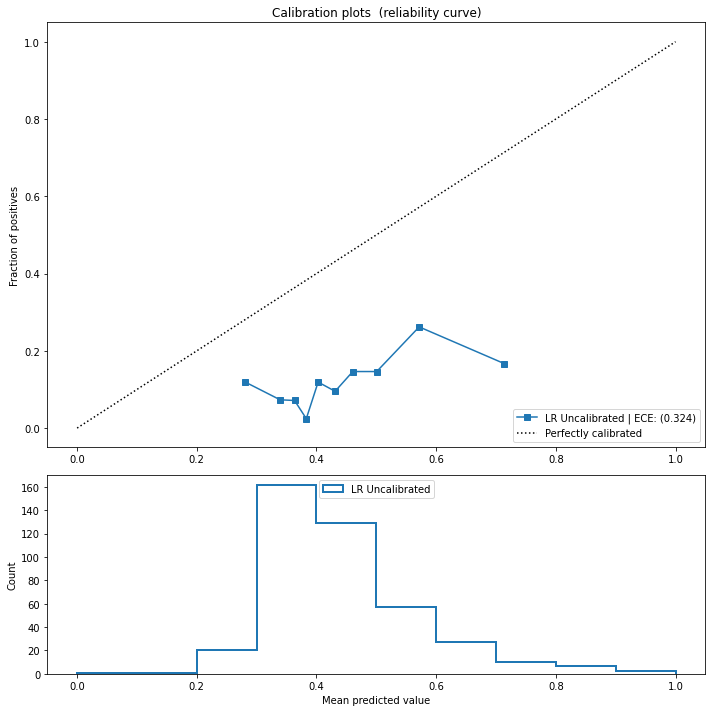

In [ ]:
reliability("LR Uncalibrated", y_test, proba_logistic_uncalibrated_refit,10,'quantile')

### Calibration Logistic Regression Platt (sigmoid)



In [ ]:
Model_logistic_refit

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Model_logistic_refit
# clf_logistic_refit

# Calibrated with sigmoid calibration
clf_logistic_refit_sigmoid = CalibratedClassifierCV(base_estimator=Model_logistic_refit, cv=4, method='sigmoid')

clf_logistic_refit_sigmoid.fit(X_train, y_train)

y_pred_logistic_refit_sigmoid = clf_logistic_refit_sigmoid.predict(X_test)
proba_logistic_refit_sigmoid = clf_logistic_refit_sigmoid.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_logistic_refit_sigmoid.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_logistic_refit_sigmoid))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_logistic_refit_sigmoid[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_logistic_refit_sigmoid))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_logistic_refit_sigmoid[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_logistic_refit_sigmoid[:,1],10))

	score: 0.880
	F1: 0.038
	Precision: 1.000
	Recall: 0.020
	bal_acc: 0.510
	auc: 0.620
	log_loss: 0.366
	Brier: 0.106
	ECE: 0.028 (smaller the better)


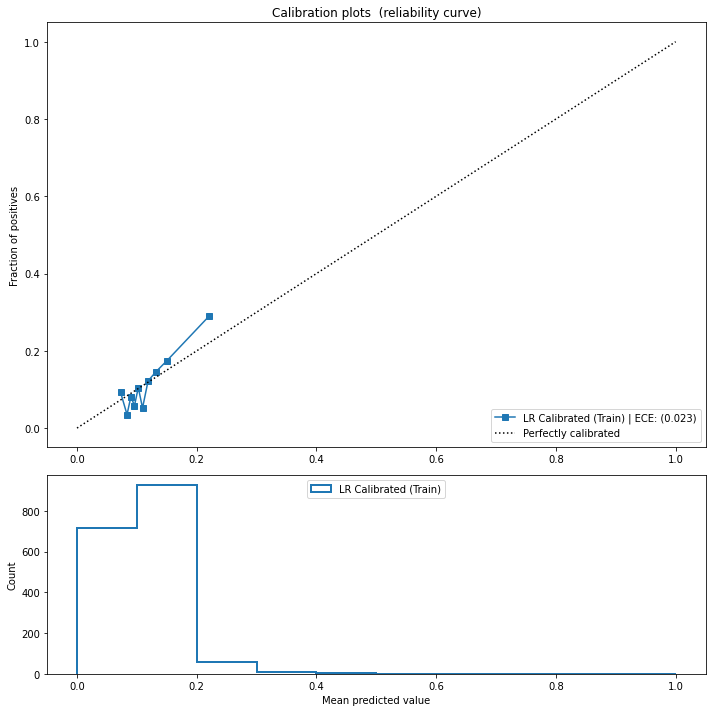

In [ ]:
reliability("LR Calibrated (Train)", y_train, clf_logistic_refit_sigmoid.predict_proba(X_train), 10,'quantile')

In [ ]:
# proba_logistic_refit_sigmoid.shape

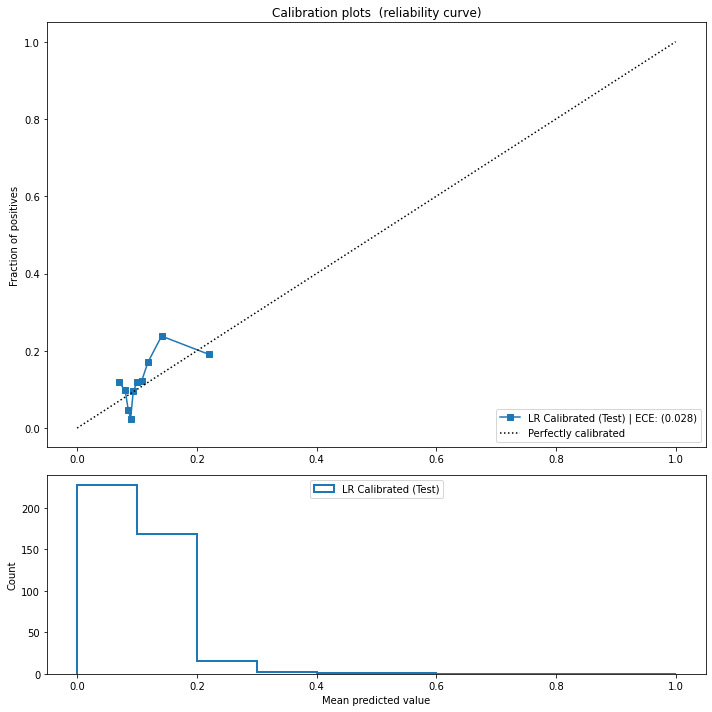

In [ ]:
reliability("LR Calibrated (Test)", y_test, proba_logistic_refit_sigmoid, 10,'quantile')

### Calibration Logistic Regression Platt (Isotonic)





In [ ]:
# Model_logistic_refit

In [ ]:
# Model_logistic_refit
# clf_logistic_refit

# Calibrated with sigmoid calibration
clf_logistic_refit_iso = CalibratedClassifierCV(base_estimator=Model_logistic_refit, cv=4, method='isotonic')

clf_logistic_refit_iso.fit(X_train, y_train)

y_pred_logistic_refit_iso = clf_logistic_refit_iso.predict(X_test)
proba_logistic_refit_iso = clf_logistic_refit_iso.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_logistic_refit_iso.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_logistic_refit_iso))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_logistic_refit_iso))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_logistic_refit_iso))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_logistic_refit_iso))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_logistic_refit_iso[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_logistic_refit_iso))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_logistic_refit_iso[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_logistic_refit_iso[:,1],10))

	score: 0.875
	F1: 0.037
	Precision: 0.333
	Recall: 0.020
	bal_acc: 0.507
	auc: 0.621
	log_loss: 0.375
	Brier: 0.108
	ECE: 0.039 (smaller the better)


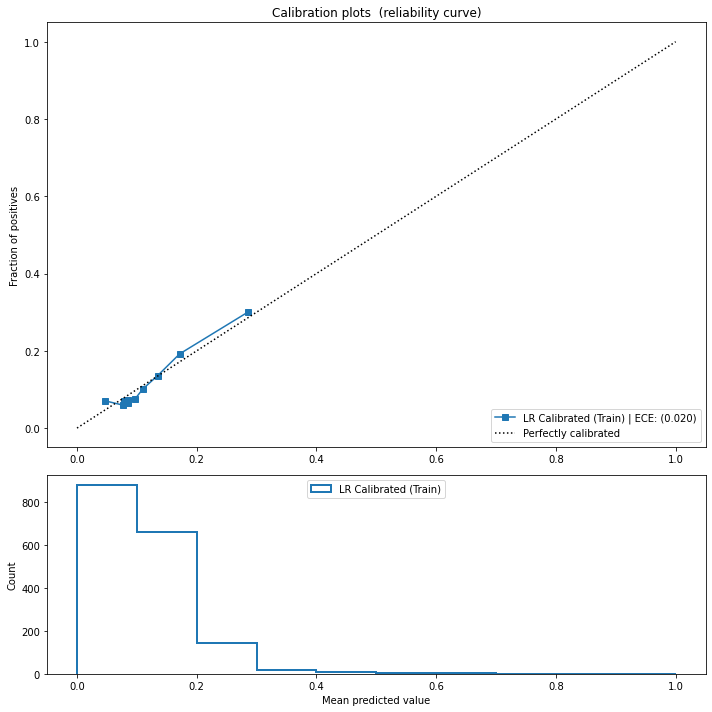

In [ ]:
reliability("LR Calibrated (Train)", y_train, clf_logistic_refit_iso.predict_proba(X_train), 10, 'quantile')

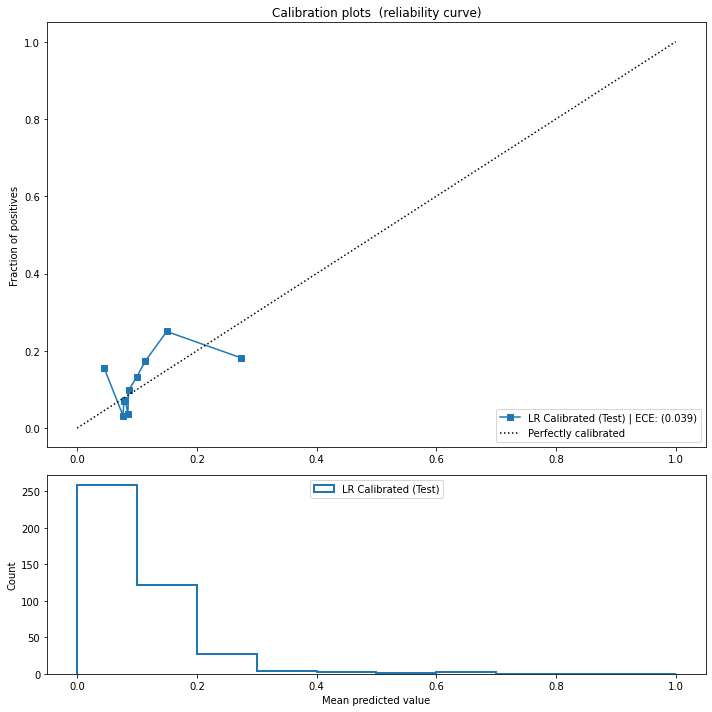

In [ ]:
reliability("LR Calibrated (Test)", y_test, proba_logistic_refit_iso, 10, 'quantile')

# Random Forest

## Normal





### Tuning Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 32, 32)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

cv = GroupKFold(n_splits=4)

In [ ]:
#############################################
##### Execution can take up to 20 minutes #####
#############################################

Model_RF = RandomForestClassifier(random_state=42)
clf_RF = RandomizedSearchCV(estimator = Model_RF, param_distributions = random_grid, n_iter = 100, cv = cv, scoring = 'brier_score_loss', verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# clf_RF.fit(X_train_overSampled, y_train_overSampled, groups_X_train_overSampled)
clf_RF.fit(X_train, y_train, groups_X_train)

print(clf_RF.best_score_)
print(clf_RF.best_params_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  7.9min finished


-0.10003692858579974
{'n_estimators': 235, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}


In [ ]:
# best_params_RF = clf_RF.best_params_
best_params_RF = {'n_estimators': 235, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}

# best_params_RF = clf_RF.best_params_
# best_params_RF = {'n_estimators': 235, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}

# Fit model with best parameters
Model_RF_refit = RandomForestClassifier(random_state=42)
Model_RF_refit.set_params(**best_params_RF)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       min_weight_fraction_leaf=0.0, n_estimators=235,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
auc_rf,logloss_rf,brier_rf,ece_rf,prop_train,prop_test,auc_iso_rf,logloss_iso_rf,brier_iso_rf,ece_iso_rf,auc_sig_rf,logloss_sig_rf,brier_sig_rf,ece_sig_rf = iterate_models(Model_RF_refit,100,0.2)

In [ ]:
# np.mean(auc_rf)
auc_rf

array([0.60542096, 0.62389593, 0.62958221, 0.72398589, 0.67068783,
       0.7004712 , 0.60745127, 0.74400387, 0.72184508, 0.58199788,
       0.62732794, 0.63734159, 0.64377999, 0.65896396, 0.6776536 ,
       0.65063738, 0.67442841, 0.63380942, 0.63793103, 0.51999429,
       0.62266322, 0.57967761, 0.70130778, 0.58982521, 0.76325827,
       0.67287496, 0.62101064, 0.64577657, 0.67409341, 0.5834901 ,
       0.76974985, 0.60914106, 0.67210516, 0.69450561, 0.55787011,
       0.67218637, 0.67141256, 0.66285925, 0.64595325, 0.66041667,
       0.68141939, 0.70543113, 0.59463419, 0.74667557, 0.6884058 ,
       0.71197591, 0.69265233, 0.73154039, 0.7489202 , 0.64883199,
       0.6532645 , 0.63688472, 0.6477027 , 0.64929419, 0.64827386,
       0.78263431, 0.74933382, 0.63998136, 0.73644034, 0.72439067,
       0.6367374 , 0.66693657, 0.6781851 , 0.75058483, 0.69506377,
       0.61368043, 0.68221642, 0.66055492, 0.55219326, 0.68230144,
       0.68529156, 0.60618395, 0.60951383, 0.62163183, 0.54872

In [ ]:
auc_iso_rf

array([0.59921444, 0.61998368, 0.62169811, 0.72525677, 0.66034392,
       0.69945026, 0.60119048, 0.73795938, 0.70855817, 0.58608507,
       0.63031377, 0.64895864, 0.64488741, 0.64468468, 0.67751863,
       0.64776349, 0.6808705 , 0.65208427, 0.62377576, 0.50339189,
       0.63632442, 0.5591825 , 0.68214036, 0.58661417, 0.7430171 ,
       0.67029301, 0.63443637, 0.64995026, 0.65645489, 0.58194482,
       0.76585224, 0.59934707, 0.69177066, 0.69054734, 0.56438677,
       0.67513021, 0.66521653, 0.64756817, 0.64542997, 0.66770833,
       0.68826994, 0.69258119, 0.59367152, 0.74761673, 0.68317482,
       0.70285088, 0.69250299, 0.73395026, 0.74586076, 0.65197664,
       0.65441176, 0.63260175, 0.63313063, 0.65371829, 0.64403829,
       0.76150303, 0.74918241, 0.63033551, 0.72247891, 0.72031399,
       0.63917772, 0.66089744, 0.67284083, 0.7381085 , 0.68356164,
       0.62498227, 0.6870322 , 0.64259153, 0.54409833, 0.69049406,
       0.68047578, 0.60596972, 0.62598582, 0.62603878, 0.55977

In [ ]:
auc_sig_rf

array([0.59834493, 0.62235983, 0.62318059, 0.73467165, 0.66486772,
       0.71465969, 0.59431285, 0.74617988, 0.72393386, 0.58767838,
       0.6312247 , 0.64996562, 0.65325458, 0.65094595, 0.68194579,
       0.63891418, 0.67644303, 0.64254386, 0.63313609, 0.53213368,
       0.62529959, 0.57040875, 0.68363782, 0.58764729, 0.74947705,
       0.67426748, 0.6237725 , 0.64564681, 0.66678271, 0.58196721,
       0.76876091, 0.60441292, 0.67993044, 0.68559295, 0.55508522,
       0.67793252, 0.66791906, 0.65212786, 0.65027036, 0.66765351,
       0.68667748, 0.69832027, 0.59584798, 0.74309308, 0.68935688,
       0.70974576, 0.68508562, 0.74117987, 0.75195393, 0.65103324,
       0.65962662, 0.64990411, 0.64963964, 0.65108429, 0.64763563,
       0.76651133, 0.74781977, 0.63643989, 0.7302799 , 0.7237835 ,
       0.64334218, 0.66443995, 0.67103795, 0.73510081, 0.70059046,
       0.63692249, 0.6878445 , 0.65860984, 0.55588048, 0.6888055 ,
       0.6924282 , 0.60232791, 0.62104422, 0.62553513, 0.55687

In [ ]:
for size in [0.2,0.3,0.5,0.8]:
  auc,logloss,brier,ece,prop_train,prop_test,auc_iso,logloss_iso,brier_iso,ece_iso,auc_sig,logloss_sig,brier_sig,ece_sig = iterate_models(Model_RF_refit,1000,size)
  print('*'*70)

  print("\tTest Set Size: %.2f\n\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (size,
                                                                                                                           auc.mean(),auc.std(),
                                                                                                                           logloss.mean(),logloss.std(),
                                                                                                                           brier.mean(),brier.std(),
                                                                                                                           ece.mean(),ece.std()) )
  print("\n")
  print("\tAUC(min): %1.3f      \tAUC(max): %1.3f"    % (auc.min(),auc.max()))
  print("\tlog_loss(min): %1.3f  \tlog_loss(max): %1.3f" % (logloss.min(),logloss.max()))
  print("\tBrier(min): %1.3f    \tBrier(max): %1.3f"   % (brier.min(),brier.max()))
  print("\tECE(min): %1.3f       \tECE(max): %1.3f"      % (ece.min(),ece.max()))
  print("\tProp train: %.2f \tProp test: %.2f" % (prop_train.mean(), prop_test.mean()))  
  print("\nIsotonic Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_iso.mean(),auc_iso.std(),
                                                                                                                           logloss_iso.mean(),logloss_iso.std(),
                                                                                                                           brier_iso.mean(),brier_iso.std(),
                                                                                                                           ece_iso.mean(),ece_iso.std()) )
  print("\nSigmoid Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_sig.mean(),auc_sig.std(),
                                                                                                                           logloss_sig.mean(),logloss_sig.std(),
                                                                                                                           brier_sig.mean(),brier_sig.std(),
                                                                                                                           ece_sig.mean(),ece_sig.std()) )

**********************************************************************
	Test Set Size: 0.20
	Mean AUC: 0.655(0.046) 
	Mean log_loss: 0.348(0.041)
	Mean Brier: 0.101(0.015) 
	Mean ECE: 0.045(0.012)


	AUC(min): 0.484      	AUC(max): 0.776
	log_loss(min): 0.236  	log_loss(max): 0.567
	Brier(min): 0.056    	Brier(max): 0.178
	ECE(min): 0.021       	ECE(max): 0.118
	Prop train: 0.20 	Prop test: 0.80

Isotonic Calibration
	Mean AUC: 0.652(0.047) 
	Mean log_loss: 0.361(0.052)
	Mean Brier: 0.102(0.015) 
	Mean ECE: 0.043(0.014)

Sigmoid Calibration
	Mean AUC: 0.656(0.046) 
	Mean log_loss: 0.349(0.042)
	Mean Brier: 0.101(0.015) 
	Mean ECE: 0.047(0.012)
**********************************************************************
	Test Set Size: 0.30
	Mean AUC: 0.652(0.036) 
	Mean log_loss: 0.348(0.031)
	Mean Brier: 0.100(0.011) 
	Mean ECE: 0.037(0.010)


	AUC(min): 0.527      	AUC(max): 0.777
	log_loss(min): 0.259  	log_loss(max): 0.446
	Brier(min): 0.067    	Brier(max): 0.138
	ECE(min): 0.013       	

In [ ]:
# clf_RF_refit = Model_RF_refit.fit(X_train_overSampled, y_train_overSampled)
clf_RF_refit = Model_RF_refit.fit(X_train, y_train)

y_pred_RF_refit = clf_RF_refit.predict(X_test)
proba_RF_uncalibrated_refit = clf_RF_refit.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_RF_refit.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_RF_refit))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_RF_refit))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_RF_refit))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_RF_refit))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_RF_uncalibrated_refit[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_RF_uncalibrated_refit))
print("\tBrier: %1.3f (smaller the better)" % brier_score_loss(y_test, proba_RF_uncalibrated_refit[:,1]))

	score: 0.877
	F1: 0.000
	Precision: 0.000
	Recall: 0.000
	bal_acc: 0.500
	auc: 0.708
	log_loss: 0.352
	Brier: 0.104 (smaller the better)


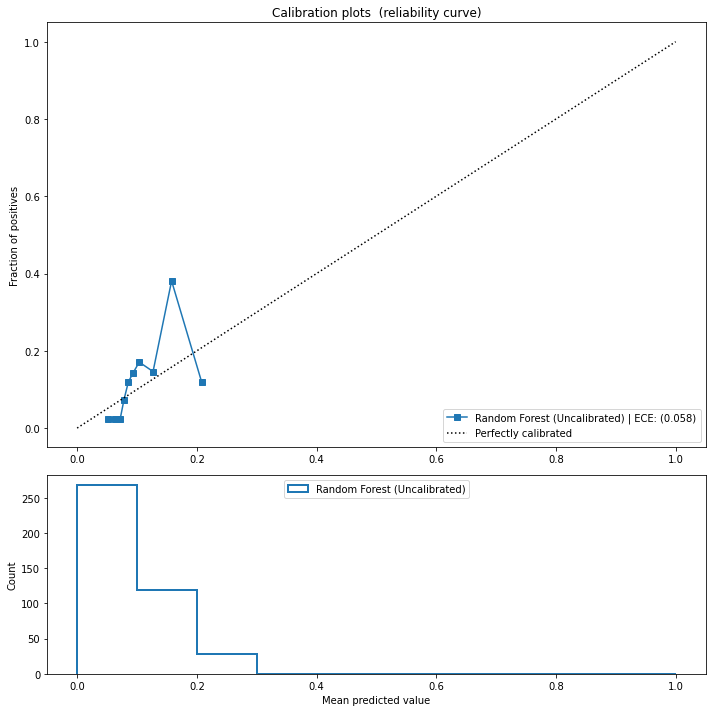

In [ ]:
reliability("Random Forest (Uncalibrated)", y_test, proba_RF_uncalibrated_refit, 10,'quantile')

### Isotonic

In [ ]:
# Fit model with best parameters
Model_RF_cali = RandomForestClassifier(random_state=42)
Model_RF_cali.set_params(**best_params_RF)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.2,
                       min_weight_fraction_leaf=0.0, n_estimators=235,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Calibrated with Isotonic Calibration 

# Using CV from calibration - with train data
clf_RF_iso = CalibratedClassifierCV(base_estimator=Model_RF_cali, cv=4, method='isotonic')
clf_RF_iso.fit(X_train, y_train)

###############################################
y_pred_RF_iso = clf_RF_iso.predict(X_test)
proba_RF_iso = clf_RF_iso.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_RF_iso.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_RF_iso))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_RF_iso))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_RF_iso))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_RF_iso))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_RF_iso[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_RF_iso))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_RF_iso[:,1]))

	score: 0.875
	F1: 0.000
	Precision: 0.000
	Recall: 0.000
	bal_acc: 0.499
	auc: 0.684
	log_loss: 0.364
	Brier: 0.108


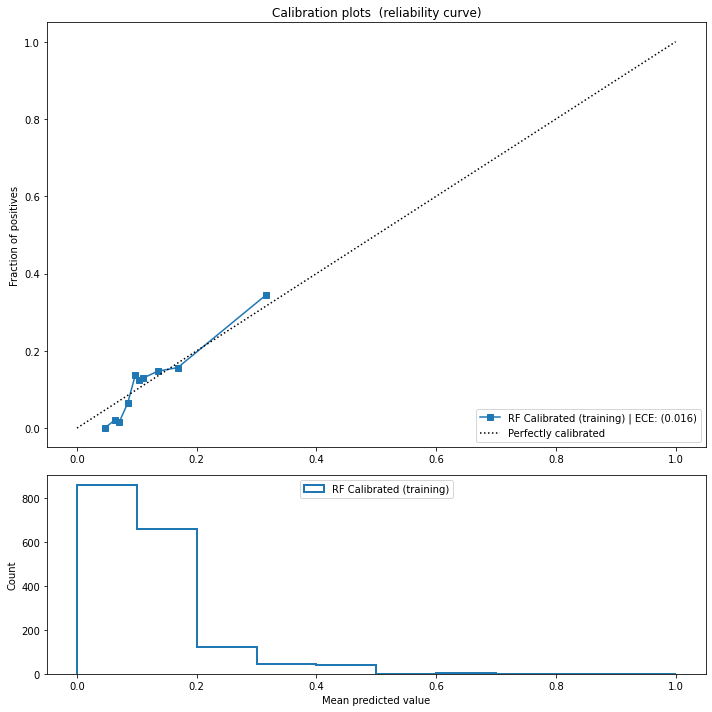

In [ ]:
reliability("RF Calibrated (training)", y_train, clf_RF_iso.predict_proba(X_train), 10, 'quantile')

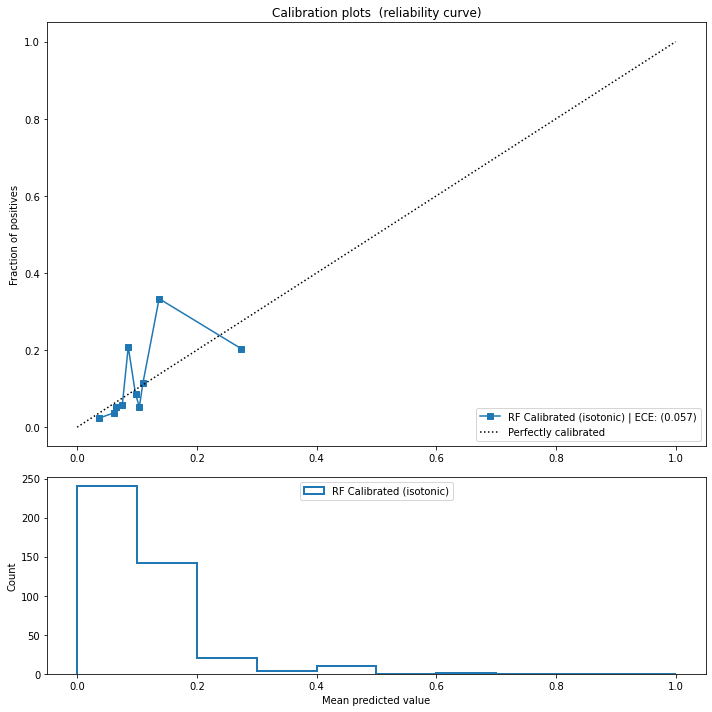

In [ ]:
reliability("RF Calibrated (isotonic)", y_test, proba_RF_iso, 10, 'quantile')

### Platt Scaling (sigmoid)

In [ ]:
# Calibrated with sigmoid Calibration 

clf_RF_sigmoid = CalibratedClassifierCV(base_estimator=Model_RF_cali, cv=4, method='sigmoid')
clf_RF_sigmoid.fit(X_train, y_train)
###############################################
y_pred_RF_sigmoid = clf_RF_sigmoid.predict(X_test)
proba_RF_sigmoid = clf_RF_sigmoid.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_RF_sigmoid.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_RF_sigmoid))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_RF_sigmoid))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_RF_sigmoid))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_RF_sigmoid))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_RF_sigmoid[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_RF_sigmoid))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_RF_sigmoid[:,1]))

	score: 0.877
	F1: 0.000
	Precision: 0.000
	Recall: 0.000
	bal_acc: 0.500
	auc: 0.699
	log_loss: 0.358
	Brier: 0.105


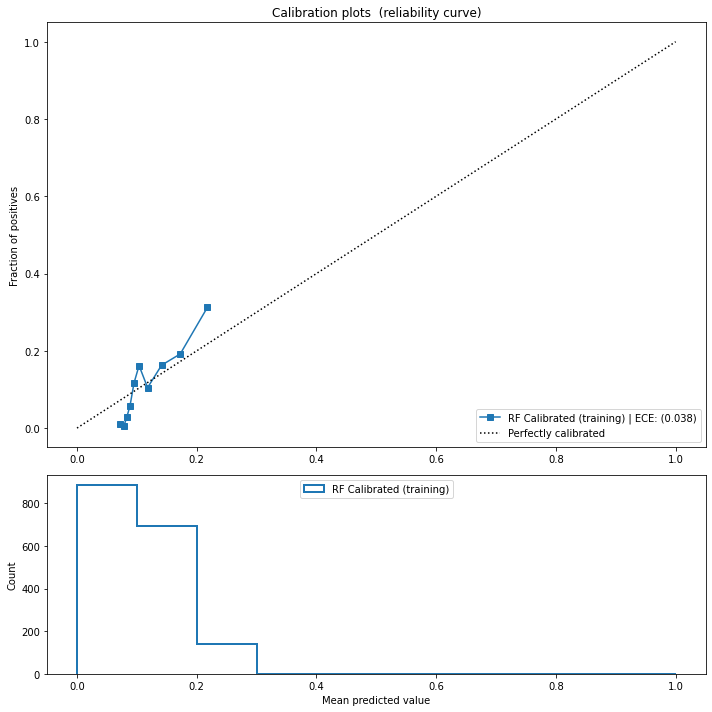

In [ ]:
reliability("RF Calibrated (training)", y_train, clf_RF_sigmoid.predict_proba(X_train), 10, 'quantile')

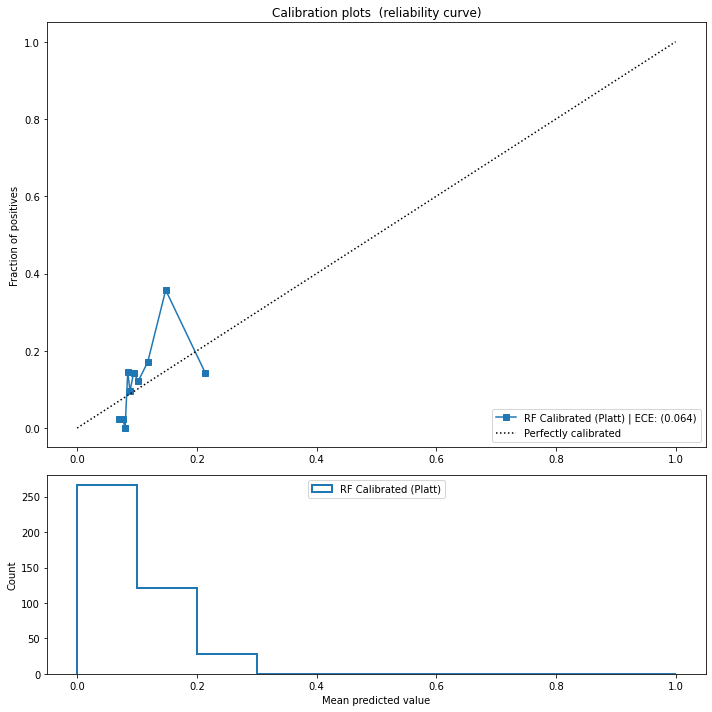

In [ ]:
reliability("RF Calibrated (Platt)", y_test, proba_RF_sigmoid, 10, 'quantile')

## with Weights

### Tuning Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 32, 32)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

cv = GroupKFold(n_splits=4)

In [ ]:
#############################################
##### Execution can take up to 20 minutes #####
#############################################

Model_RF = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_RF = RandomizedSearchCV(estimator = Model_RF, param_distributions = random_grid, n_iter = 100, cv = cv, scoring = 'brier_score_loss', verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
clf_RF.fit(X_train, y_train, groups_X_train)

print(clf_RF.best_score_)
print(clf_RF.best_params_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  8.1min finished


-0.21962254530204608
{'n_estimators': 1185, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 31, 'bootstrap': True}


In [ ]:
# best_params_RF = clf_RF.best_params_
best_params_RF = {'n_estimators': 1185, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 31, 'bootstrap': True}

# Fit model with best parameters
Model_RF_refit_weights = RandomForestClassifier(random_state=42, class_weight='balanced')
Model_RF_refit_weights.set_params(**best_params_RF)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=31, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=1185,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
auc_rfw,logloss_rfw,brier_rfw,ece_rfw,prop_train,prop_test,auc_iso_rfw,logloss_iso_rfw,brier_iso_rfw,ece_iso_rfw,auc_sig_rfw,logloss_sig_rfw,brier_sig_rfw,ece_sig_rfw = iterate_models(Model_RF_refit_weights,100,0.2)

In [ ]:
auc_rfw

array([0.61576141, 0.65432099, 0.61028669, 0.5493356 , 0.68691425,
       0.65138067, 0.6359941 , 0.60684143, 0.60385841, 0.60984848,
       0.65226095, 0.63235897, 0.66272972, 0.5923018 , 0.66877912,
       0.5921164 , 0.6554866 , 0.64910326, 0.55443561, 0.59422893,
       0.62381671, 0.57820219, 0.70255389, 0.67890925, 0.67782679,
       0.64523519, 0.65987858, 0.59272164, 0.59456654, 0.61685039,
       0.62290615, 0.6640955 , 0.61912145, 0.58951884, 0.63668605,
       0.60487232, 0.58467023, 0.64618801, 0.70160388, 0.65882992,
       0.66078509, 0.6112079 , 0.62022501, 0.67733333, 0.64520441,
       0.6200555 , 0.64859982, 0.73892196, 0.61942568, 0.73497442,
       0.63441839, 0.7012069 , 0.59396566, 0.65815552, 0.51664599,
       0.61409677, 0.62398351, 0.67642508, 0.66987353, 0.62803956,
       0.6054358 , 0.65463052, 0.46899688, 0.60079365, 0.59036844,
       0.57971242, 0.54364116, 0.59386869, 0.57901278, 0.65290867,
       0.72196809, 0.60284215, 0.52755659, 0.57499011, 0.57469

In [ ]:
auc_iso_rfw

In [ ]:
auc_sig_rfw

In [1]:
# auc_rfw.tolist()

In [ ]:
for size in [0.2,0.3,0.5,0.8]:
  auc,logloss,brier,ece,prop_train,prop_test,auc_iso,logloss_iso,brier_iso,ece_iso,auc_sig,logloss_sig,brier_sig,ece_sig = iterate_models(Model_RF_refit_weights,100,size)
  print('*'*70)

  print("\tTest Set Size: %.2f\n\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (size,
                                                                                                                           auc.mean(),auc.std(),
                                                                                                                           logloss.mean(),logloss.std(),
                                                                                                                           brier.mean(),brier.std(),
                                                                                                                           ece.mean(),ece.std()) )
  print("\n")
  print("\tAUC(min): %1.3f      \tAUC(max): %1.3f"    % (auc.min(),auc.max()))
  print("\tlog_loss(min): %1.3f  \tlog_loss(max): %1.3f" % (logloss.min(),logloss.max()))
  print("\tBrier(min): %1.3f    \tBrier(max): %1.3f"   % (brier.min(),brier.max()))
  print("\tECE(min): %1.3f       \tECE(max): %1.3f"      % (ece.min(),ece.max()))
  print("\tProp train: %.2f \tProp test: %.2f" % (prop_train.mean(), prop_test.mean()))  
  print("\nIsotonic Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_iso.mean(),auc_iso.std(),
                                                                                                                           logloss_iso.mean(),logloss_iso.std(),
                                                                                                                           brier_iso.mean(),brier_iso.std(),
                                                                                                                           ece_iso.mean(),ece_iso.std()) )
  print("\nSigmoid Calibration")
  print("\tMean AUC: %1.3f(%1.3f) \n\tMean log_loss: %1.3f(%1.3f)\n\tMean Brier: %1.3f(%1.3f) \n\tMean ECE: %1.3f(%1.3f)" % (auc_sig.mean(),auc_sig.std(),
                                                                                                                           logloss_sig.mean(),logloss_sig.std(),
                                                                                                                           brier_sig.mean(),brier_sig.std(),
                                                                                                                           ece_sig.mean(),ece_sig.std()) )

**********************************************************************
	Test Set Size: 0.20
	Mean AUC: 0.644(0.049) 
	Mean log_loss: 0.640(0.019)
	Mean Brier: 0.224(0.009) 
	Mean ECE: 0.350(0.022)


	AUC(min): 0.462      	AUC(max): 0.755
	log_loss(min): 0.583  	log_loss(max): 0.704
	Brier(min): 0.196    	Brier(max): 0.255
	ECE(min): 0.292       	ECE(max): 0.402
	Prop train: 0.20 	Prop test: 0.80

Isotonic Calibration
	Mean AUC: 0.643(0.049) 
	Mean log_loss: 0.352(0.048)
	Mean Brier: 0.100(0.015) 
	Mean ECE: 0.042(0.012)

Sigmoid Calibration
	Mean AUC: 0.646(0.049) 
	Mean log_loss: 0.344(0.041)
	Mean Brier: 0.099(0.015) 
	Mean ECE: 0.045(0.011)
**********************************************************************
	Test Set Size: 0.30
	Mean AUC: 0.641(0.034) 
	Mean log_loss: 0.635(0.018)
	Mean Brier: 0.221(0.009) 
	Mean ECE: 0.345(0.018)


	AUC(min): 0.497      	AUC(max): 0.735
	log_loss(min): 0.591  	log_loss(max): 0.691
	Brier(min): 0.200    	Brier(max): 0.249
	ECE(min): 0.296       	

# ad-hoc

In [ ]:
clf_RF_refit = Model_RF_refit.fit(X_train, y_train)

y_pred_RF_refit = clf_RF_refit.predict(X_test)
proba_RF_uncalibrated_refit = clf_RF_refit.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_RF_refit.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_RF_refit))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_RF_refit))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_RF_refit))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_RF_refit))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_RF_uncalibrated_refit[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_RF_uncalibrated_refit))
print("\tBrier: %1.3f (smaller the better)" % brier_score_loss(y_test, proba_RF_uncalibrated_refit[:,1]))

### Isotonic

In [ ]:
# Fit model with best parameters
Model_RF_cali = RandomForestClassifier(random_state=42, class_weight='balanced')
Model_RF_cali.set_params(**best_params_RF)

In [ ]:
# Calibrated with Isotonic Calibration 
clf_RF_iso = CalibratedClassifierCV(base_estimator=Model_RF_cali, cv=4, method='isotonic')
clf_RF_iso.fit(X_train, y_train)

y_pred_RF_iso = clf_RF_iso.predict(X_test)
proba_RF_iso = clf_RF_iso.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_RF_iso.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_RF_iso))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_RF_iso))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_RF_iso))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_RF_iso))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_RF_iso[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_RF_iso))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_RF_iso[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_RF_iso[:,1],10))

In [ ]:
reliability("RF Calibrated (training)", y_train, clf_RF_iso.predict_proba(X_train), 10, 'quantile')

In [ ]:
reliability("RF Calibrated (isotonic)", y_test, proba_RF_iso, 10, 'quantile')

In [ ]:
# first column is the average predicted probability, second is the empirical, and last the number of observations
# pd.concat([pd.DataFrame(rd['pred_probs']),pd.DataFrame(rd['emp_probs']),pd.DataFrame(rd['bin_counts'])], axis=1, join="inner")

### Platt Scaling (sigmoid)

In [ ]:
# Calibrated with sigmoid Calibration 

# Using CV from calibration - with oversampled train data
clf_RF_sigmoid = CalibratedClassifierCV(base_estimator=Model_RF_cali, cv=4, method='sigmoid')
clf_RF_sigmoid.fit(X_train, y_train)

###############################################
y_pred_RF_sigmoid = clf_RF_sigmoid.predict(X_test)
proba_RF_sigmoid = clf_RF_sigmoid.predict_proba(X_test)

In [ ]:
print("\tscore: %1.3f" % clf_RF_sigmoid.score(X_test, y_test))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_RF_sigmoid))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_RF_sigmoid))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_RF_sigmoid))
print("\tbal_acc: %1.3f" % balanced_accuracy_score(y_test, y_pred_RF_sigmoid))
print("\tauc: %1.3f" % roc_auc_score(y_test, proba_RF_sigmoid[:,1]))
print("\tlog_loss: %1.3f" % log_loss(y_test, proba_RF_sigmoid))
print("\tBrier: %1.3f" % brier_score_loss(y_test, proba_RF_sigmoid[:,1]))
print("\tECE: %1.3f (smaller the better)" % expected_calibration_error(y_test, proba_RF_sigmoid[:,1],10))

In [ ]:
reliability("RF Calibrated (training)",y_train, clf_RF_sigmoid.predict_proba(X_train), 10, 'quantile')

In [ ]:
reliability("RF Calibrated (Platt)", y_test, proba_RF_sigmoid, 10, 'quantile')

# Results

In [ ]:
# X_train = X_train.iloc[:,1:]
X_train.shape, X_test.shape
# X_train.head()

((1723, 11), (416, 11))

In [ ]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=4, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=4, method='sigmoid')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        prob_pos = clf.predict_proba(X_test)[:, 1]

        # clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        clf_score = expected_calibration_error(y_test, prob_pos,13)
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=13, strategy='quantile')

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=13, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    # ax1.legend(loc="lower right")
    ax1.legend(loc="best",fontsize=20)
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [ ]:
def plot_calibration_curve_1(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=4, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=4, method='sigmoid')

    fig = plt.figure(fig_index, figsize=(10, 10))

    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        prob_pos = clf.predict_proba(X_test)[:, 1]

        # clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        clf_score = expected_calibration_error(y_test, prob_pos,10)
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10, strategy='quantile')

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="best")
    ax1.set_title('Calibration plots  (reliability curve)')
    
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [ ]:
from google.colab import files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

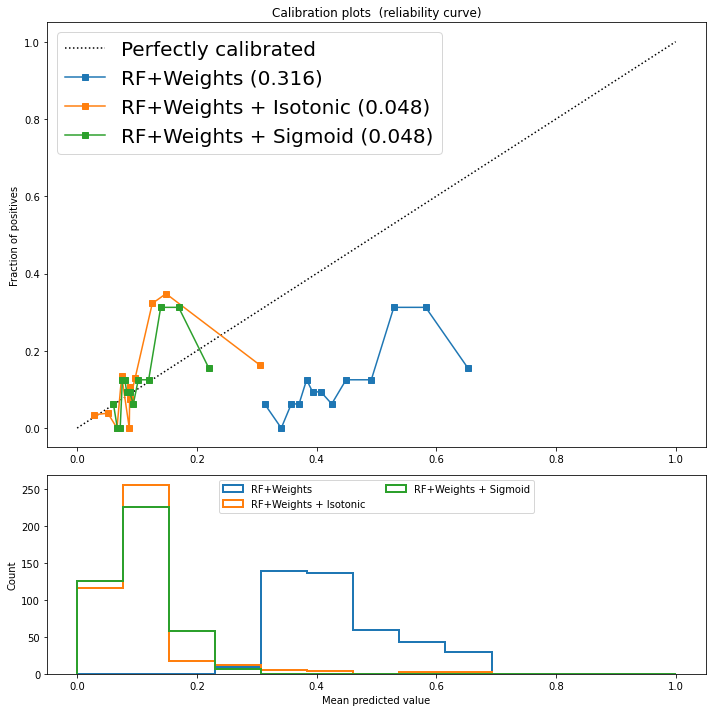

In [ ]:
plot_calibration_curve(Model_RF_refit_weights, "RF+Weights", 1)
plt.savefig('rfw_calibration.png', bbox_inches = 'tight')
files.download("rfw_calibration.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

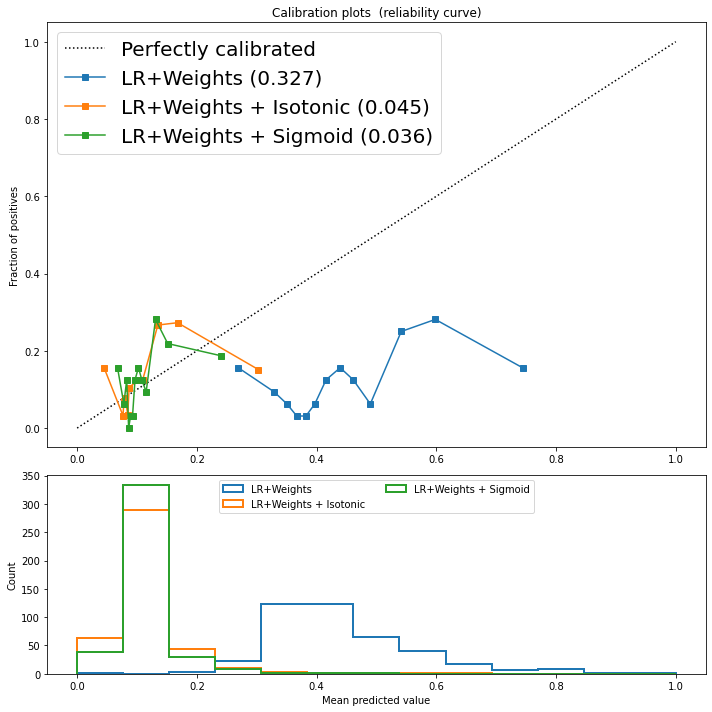

In [ ]:
plot_calibration_curve(Model_logistic_refit, "LR+Weights", 1)
plt.savefig('lrw_calibration.png', bbox_inches = 'tight')
files.download("lrw_calibration.png") 

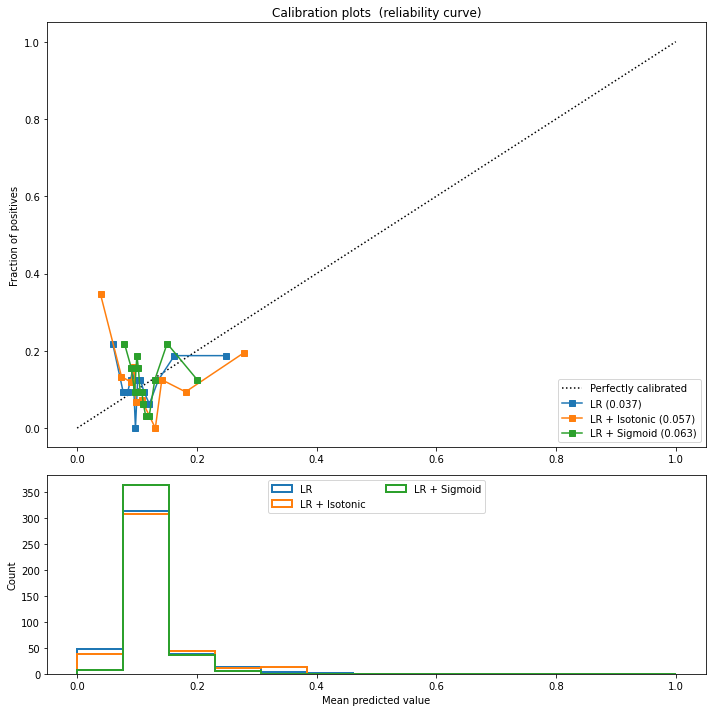

In [ ]:
plot_calibration_curve(Model_logistic_refit, "LR", 1)
# plt.savefig('lr_calibration.png', bbox_inches = 'tight')
# files.download("lrw_calibration.png") 